# Assignment 5 - MNIST with Convolutional Networks

Machine Learning

Richard Teller

First let's import the libraries we need, define some convenience variables, and import the MNIST dataset.

In [252]:
# Imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math

In [253]:
# Let's define some variables for numbers that we already know and import the MNIST dataset:

img_size = 28                       # MNIST images are 28x28
img_size_flat = img_size * img_size # the input to a layer is the image flattened
img_shape = (img_size, img_size)    # create a tuple to be used to reshape arrays.
num_channels = 1                    # MNIST images are grayscale and thus only have one channel

num_classes = 10                    # We have 10 classes, 1 for each digit 0-9

# Now let's import the MNIST data set
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Now before we start creating the CNN Models, lets make some helper functions to streamline the process.

In [254]:
# Helper Functions for creating the CNN Models

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

# function for custom creating a conv layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   stride,             # Stride size
                   num_filters,        # Number of filters.
                   padding_type):      # Padding type to apply.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights (filters) with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the layer
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, stride, stride, 1],
                         padding=padding_type)

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use the relu activation function
    layer = tf.nn.relu(layer)
    
    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

# function for custom creating a max pooling layer
def new_pooling_layer(input_layer, ksize, padding_type):
    # create the pooling layer
    layer = tf.nn.max_pool(value=input_layer,
                           ksize=[1, ksize, ksize, 1],
                           strides=[1, ksize, ksize, 1],
                           padding=padding_type)
    return layer

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

# function for custom creating a fully connected layer
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # use ReLU?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases
    
    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# function used to train the model
def optimize(num_iterations, batch_size):
    
    for i in range(num_iterations):

        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 1000 iterations.
        if (i+1) % 1000 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Print message.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1, acc))

    print("\n")

# function used to run the model against the test set and retrieve the accuracy
def evaluate_and_print_metrics(test_batch_size):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(data.test.labels, axis=1)
    
    # Print the metrics
    print("Accuracy on Test-Set:", accuracy_score(cls_true, cls_pred), "\n")
    print("Classification Report:\n\n", classification_report(cls_true, cls_pred), "\n")
    print("Confusion Matrix:\n\n", confusion_matrix(cls_true,cls_pred))

In [255]:
# Helper Functions for questions 3 and 4

def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')
    plt.show()

# takes an imput image and applies the convolutions from the given layer to the image
def plot_conv_layer(layer, image):
    
    # Create a feed-dict containing just one image.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Create a square grid of subplots, so take the square
    # root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# function that plots the convolution kernels as matrices
def plot_conv_weights_as_matrix(weights, input_channel=0):
    
    # Retrieve the values of the weight-variables
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Create a square grid of subplots, so take the square
    # root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            img = w[:, :, input_channel, i]
            kernel = np.asarray(img)
            
            filt = np.copy(kernel)
            filt.resize(filt.shape[0], filt.shape[1], 1, 1)
            
            # Plot the matrix
            plt.gray() 
            ax.matshow(kernel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        
    plt.show()

In [256]:
# Define some placeholder variables for the models to use
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Now let's begin creating our CNN models:

## First Model

- One conv layer: 
 - 5x5 kernels
 - stride=1
 - 16 kernels
 - padding=SAME
 
 
- One pooling layer: 
 - size=2x2
 - padding=SAME
 
 
- One fully connected layer
 - 64 nodes
 
 
- One softmax output layer

In [257]:
# Define our model:

# create convolutional layer
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=5,                   # 5x5 kernel
                                            stride=1,
                                            num_filters=16,                  # 16 kernels
                                            padding_type='SAME')

# create max pool layer
layer_pool1 = new_pooling_layer(input_layer=layer_conv1, ksize=2, padding_type='SAME')

# create flattened layer
layer_flat, num_features = flatten_layer(layer_pool1)

# create fully connected layer, 64 nodes
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=64,
                         use_relu=True)

# create output layer
output = new_fc_layer(input=layer_fc1,
                         num_inputs=64,
                         num_outputs=num_classes,
                         use_relu=False)

# get our predictions
y_pred = tf.nn.softmax(output)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# define our cost function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# get the true values and accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# The model has been defined, now let's run it
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=10000, batch_size=64)
evaluate_and_print_metrics(test_batch_size=256)
session.close()

Optimization Iteration:   1000, Training Accuracy:  87.5%
Optimization Iteration:   2000, Training Accuracy:  92.2%
Optimization Iteration:   3000, Training Accuracy:  90.6%
Optimization Iteration:   4000, Training Accuracy:  90.6%
Optimization Iteration:   5000, Training Accuracy:  98.4%
Optimization Iteration:   6000, Training Accuracy:  96.9%
Optimization Iteration:   7000, Training Accuracy:  98.4%
Optimization Iteration:   8000, Training Accuracy:  98.4%
Optimization Iteration:   9000, Training Accuracy:  98.4%
Optimization Iteration:  10000, Training Accuracy: 100.0%


Accuracy on Test-Set: 0.9763 

Classification Report:

              precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.97      0.97      0.97      1032
          3       0.98      0.99      0.98      1010
          4       0.97      0.99      0.98       982
          5       0.98      0.98      0.98 

## Second Model

- One conv layer: 
 - 3x3 kernels
 - stride=2
 - 64 kernels
 - padding=SAME
 
 
- One pooling layer: 
 - size=2x2
 - padding=VALID
 
 
- One fully connected layer
 - 128 nodes
 
 
- One softmax output layer

In [258]:
# Define our model:

# create convolutional layer
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=3,                   # 3x3 kernel
                                            stride=2,
                                            num_filters=64,                  # 64 kernels
                                            padding_type='SAME')

# create max pool layer
layer_pool1 = new_pooling_layer(input_layer=layer_conv1, ksize=2, padding_type='VALID')

# create flattened layer
layer_flat, num_features = flatten_layer(layer_pool1)

# create fully connected layer, 128 nodes
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=128,
                         use_relu=True)

# create output layer
output = new_fc_layer(input=layer_fc1,
                         num_inputs=128,
                         num_outputs=num_classes,
                         use_relu=False)

# get our predictions
y_pred = tf.nn.softmax(output)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# define our cost function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# get the true values and accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# The model has been defined, now let's run it
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=10000, batch_size=64)
evaluate_and_print_metrics(test_batch_size=256)
session.close()

Optimization Iteration:   1000, Training Accuracy:  89.1%
Optimization Iteration:   2000, Training Accuracy:  93.8%
Optimization Iteration:   3000, Training Accuracy:  92.2%
Optimization Iteration:   4000, Training Accuracy:  98.4%
Optimization Iteration:   5000, Training Accuracy:  92.2%
Optimization Iteration:   6000, Training Accuracy:  95.3%
Optimization Iteration:   7000, Training Accuracy:  98.4%
Optimization Iteration:   8000, Training Accuracy:  96.9%
Optimization Iteration:   9000, Training Accuracy: 100.0%
Optimization Iteration:  10000, Training Accuracy:  96.9%


Accuracy on Test-Set: 0.9723 

Classification Report:

              precision    recall  f1-score   support

          0       0.98      0.98      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.97      0.96      0.97      1032
          3       0.97      0.97      0.97      1010
          4       0.98      0.97      0.98       982
          5       0.98      0.97      0.97 

## Third Model

- First conv layer: 
 - 3x3 kernels
 - stride=1
 - 32 kernels
 - padding=SAME
 
 
- Second conv layer: 
 - 3x3 kernels
 - stride=2
 - 64 kernels
 - padding=SAME
 
 
- One pooling layer: 
 - size=2x2
 - padding=VALID
 
 
- One fully connected layer
 - 128 nodes
 
 
- One softmax output layer

In [259]:
# Define our model:

# create first convolutional layer
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=3,                   # 3x3 kernel
                                            stride=1,
                                            num_filters=32,                  # 32 kernels
                                            padding_type='SAME')

# create second convolutional layer
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=32,           # num filters from conv1
                                            filter_size=3,                   # 3x3 kernel
                                            stride=2,
                                            num_filters=64,                  # 64 kernels
                                            padding_type='SAME')

# create max pool layer
layer_pool1 = new_pooling_layer(input_layer=layer_conv2, ksize=2, padding_type='VALID')

# create flattened layer
layer_flat, num_features = flatten_layer(layer_pool1)

# create fully connected layer, 128 nodes
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=128,
                         use_relu=True)

# create output layer
output = new_fc_layer(input=layer_fc1,
                         num_inputs=128,
                         num_outputs=num_classes,
                         use_relu=False)

# get our predictions
y_pred = tf.nn.softmax(output)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# define our cost function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# get the true values and accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# The model has been defined, now let's run it
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=10000, batch_size=64)
evaluate_and_print_metrics(test_batch_size=256)
session.close()

Optimization Iteration:   1000, Training Accuracy:  92.2%
Optimization Iteration:   2000, Training Accuracy:  95.3%
Optimization Iteration:   3000, Training Accuracy:  95.3%
Optimization Iteration:   4000, Training Accuracy:  98.4%
Optimization Iteration:   5000, Training Accuracy:  96.9%
Optimization Iteration:   6000, Training Accuracy: 100.0%
Optimization Iteration:   7000, Training Accuracy:  98.4%
Optimization Iteration:   8000, Training Accuracy:  98.4%
Optimization Iteration:   9000, Training Accuracy:  98.4%
Optimization Iteration:  10000, Training Accuracy:  98.4%


Accuracy on Test-Set: 0.9834 

Classification Report:

              precision    recall  f1-score   support

          0       0.97      1.00      0.98       980
          1       0.99      1.00      0.99      1135
          2       0.98      0.99      0.98      1032
          3       0.97      1.00      0.98      1010
          4       0.99      0.99      0.99       982
          5       0.99      0.98      0.99 

## Fourth Model

- First conv layer: 
 - 4x4 kernels
 - stride=1
 - 16 kernels
 - padding=SAME
 
 
- Second conv layer: 
 - 5x5 kernels
 - stride=2
 - 64 kernels
 - padding=SAME
 
 
- One pooling layer: 
 - size=2x2
 - padding=VALID
 
 
- First fully connected layer
 - 128 nodes


- Second fully connected layer
 - 64 nodes


- One softmax output layer

Note: We will keep the session of this model running to answer questions 3 and 4.

In [239]:
# Define our model:

# create first convolutional layer
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=4,                   # 4x4 kernel
                                            stride=1,
                                            num_filters=16,                  # 16 kernels
                                            padding_type='SAME')

# create second convolutional layer
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=16,           # num filters from conv1
                                            filter_size=5,                   # 5x5 kernel
                                            stride=2,
                                            num_filters=64,                  # 64 kernels
                                            padding_type='SAME')

# create max pool layer
layer_pool1 = new_pooling_layer(input_layer=layer_conv2, ksize=2, padding_type='VALID')

# create flattened layer
layer_flat, num_features = flatten_layer(layer_pool1)

# create first fully connected layer, 128 nodes
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=128,
                         use_relu=True)

# create second fully connected layer, 64 nodes
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=128,
                         num_outputs=64,
                         use_relu=True)

# create output layer
output = new_fc_layer(input=layer_fc2,
                         num_inputs=64,
                         num_outputs=num_classes,
                         use_relu=False)

# get our predictions
y_pred = tf.nn.softmax(output)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# define our cost function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# get the true values and accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# The model has been defined, now let's run it
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=5000, batch_size=64)
evaluate_and_print_metrics(test_batch_size=256)

Optimization Iteration:   1000, Training Accuracy:  93.8%
Optimization Iteration:   2000, Training Accuracy:  93.8%
Optimization Iteration:   3000, Training Accuracy: 100.0%
Optimization Iteration:   4000, Training Accuracy:  98.4%
Optimization Iteration:   5000, Training Accuracy:  96.9%


Accuracy on Test-Set: 0.9812 

Classification Report:

              precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.99      0.98      0.98      1010
          4       0.99      0.98      0.98       982
          5       0.99      0.97      0.98       892
          6       0.99      0.98      0.99       958
          7       0.97      0.98      0.98      1028
          8       0.98      0.97      0.98       974
          9       0.97      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000
 

Confusion M

### Questions

**How many hidden layers are in your network?**

The hidden layers are all the layers except for the input layer and the output layer.  This includes any convolutional layer, max pooling layer, flattened layer, or inner fully connected layer.  The hidden layers are denoted in bold.

Model 1 has 4 hidden layers: [input] -> **[conv] -> [pool] -> [flatten] -> [fc]** -> [output]


Model 2 has 4 hidden layers: [input] -> **[conv] -> [pool] -> [flatten] -> [fc]** -> [output]


Model 3 has 5 hidden layers: [input] -> **[conv1] -> [conv2] -> [pool] -> [flatten] -> [fc]** -> [output]


Model 4 has 6 hidden layers: [input] -> **[conv1] -> [conv2] -> [pool] -> [flatten] -> [fc1] -> [fc2]** -> [output]


**How many convolutions are calculated in each convolution layer?**

A convolution refers to each time a kernel is applied to the input image, thus we will have the same number of convolutions as we do number of kernels for each convolutional layer.  Also, each time a kernel is applied to the input image we get a new image, and so for a 16 kernel convolutional layer, we would get 16 output images for our one input image.  The number of convolutions in each convolutional layer for each model are:

Model 1:
 - conv layer1: 16


Model 2:
 - conv layer1: 64


Model 3:
 - conv layer1: 32
 - conv layer2: 64


Model 4:
 - conv layer1: 16
 - conv layer2: 64
 
 
**Run a single test example through the model and print some of the convolved images from the first layer.  Can you see any features from the image that are revealed by printing?**

Let's do this but with 4 images.  Doing so will make it easier to compare features between digits to see how the shape of the digit might make a difference.  We will run these images against Model 4 (the session is still running).

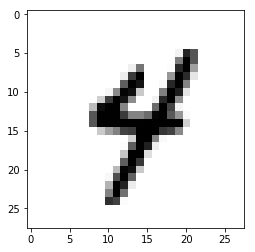

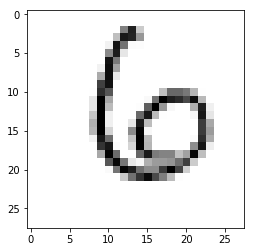

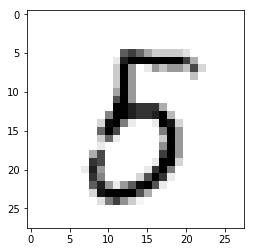

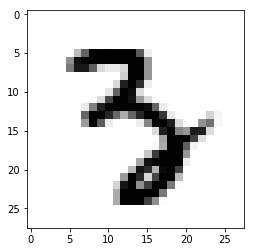

In [240]:
# Choose 4 random images to run through the convolution from Model 4

image1 = data.test.images[5047]
plot_image(image1)

image2 = data.test.images[100]
plot_image(image2)

image3 = data.test.images[45]
plot_image(image3)

image4 = data.test.images[87]
plot_image(image4)

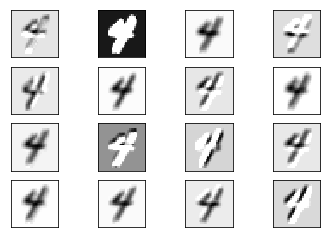

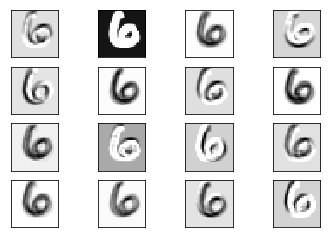

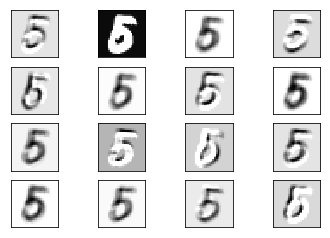

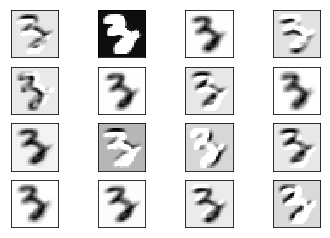

In [241]:
# Now plot the digits after applying the first convolutional layer's kernels

plot_conv_layer(layer=layer_conv1, image=image1)
plot_conv_layer(layer=layer_conv1, image=image2)
plot_conv_layer(layer=layer_conv1, image=image3)
plot_conv_layer(layer=layer_conv1, image=image4)

In general it seems like most of the kernels do one of few things.  They either appear to add an artificial light source to the image, they blur the image a certain direction, or the entire digit is intensified (entire digit is one bright shade, no dimming around the edges, just sharp edges).


- The kernel in row 1 column 2 is a good example of that last feature mentioned.  All the images relating to this kernel have forced the digit to appear very defined in bright white, and although the digit is thicker, the intense color of this convolution seems to make up for any information lost due to the thickness of the digit because at a glance these images look the most noticable of what digit they are, there's no extra information, just the plain shape of the digit.


- The images for each digit at row 4 column 1 are all blurred, with what appears to be no color or light alteration, just a flat blur to the digit.  One reason I can see this being a good thing is that it will make areas where the person already drew lightly, even lighter and less noticeable.  Naturally, where you are writing lighter is most likely where you are picking up or placing your pen, and thus its probably not a defining part of the letter or number you are writing. It would make sense that even further blurring out these lighter areas would be a good thing because it would be essentially getting rid of areas that aren't important.


- The images for each digit at row 2 column 1 give the digits 3D properties.  This seems to be a good thing for digits that are round, because it gives shadows a chance to really stand out with the curvature of the digit.  By looking at the 6 and then at the 4 you can really tell that the 6 benefits from this convolution more.  While the 4 does stand out a lot as well, the swirl of the 6 is captured very well because of this convolution.

**Print a couple of the convolution kernels as matrices (no need to print images).  What kind of patterns can you see in the convolution kernels?**

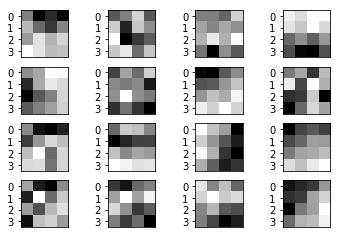

In [242]:
plot_conv_weights_as_matrix(weights=weights_conv1)

- By comparing the kernels to the convolved images from above, the most prominent feature that I see is that in general, where the darker spots are in the kernel is the same as where the shadows are in the convolved images.  So for example, if the kernel has darker values in the upper left corner, and the bottom right has lighter values, then the convolved image will appear to have shadows coming from the top left and hence an artificial light source from the bottom right.  The kernel in row 2 column 3 is perfectly representing this (take a look at its convolved images above).


- If the kernel has a large difference between its darkest value and lightest value, the convolved image will appear to have a strong three dimensional shape.  This three dimensionality is so prominent it almost looks like the image was drawn using a big blotch of paint.  Any kernel that has an obvious smooth gradient to it is a good example of this (row 2 column 3, row 3 column 3, row 3 column 4, row 4 column 4).


- In the kernels where there isn't a gradient of dark to light or light to dark, a blurring effect seems to take precedence.  Taking the kernel at row 2 column 2 for example, the images it produced were simply blurred with no apparent direction.  However, it appears if there is a line of lighter values in the kernel in a particular direction, the blur will follow that same direction, as in the kernel at row 3 column 2 with its horizontal white line on the bottom, you can see that the horizontal top part of the 3 is very sharp but vertical areas, even in the other digits, are distorted like a sort of double vision.

In [243]:
# We are now done answering the questions and so we can end the session for Model 4
session.close()